In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from collections import namedtuple, defaultdict, Counter, OrderedDict

In [2]:
sns.set_context("poster")
sns.set_style("ticks")

In [3]:
DATA_DIR="data/data/"
CLEANED_DIR="data/cleaned/"

Tag = namedtuple("Tag", ["token", "tag"])

def load_sequences(filename, sep="\t", notypes=False):
    tag_count = defaultdict(int)
    sequences = []
    with open(filename) as fp:
        seq = []
        for line in fp:
            line = line.strip()
            if line:
                line = line.split(sep)
                if notypes:
                    line[1] = line[1][0]
                tag_count[line[1]] += 1
                #print line
                seq.append(Tag(*line))
            else:
                sequences.append(seq)
                seq = []
        if seq:
            sequences.append(seq)
    return sequences, tag_count

def count_phrases(sequences, ptype="movie"):
    phrase_counts = defaultdict(int)
    check_tag = ptype
    for seq in sequences:
        phrase = ""
        for tag in seq:
            if not phrase and tag.tag == "B-%s" % check_tag:
                phrase = tag.token
                continue
            if tag.tag == "I-%s" % check_tag:
                phrase += " %s" % tag.token
                continue
            if phrase:
                phrase_counts[phrase] += 1
                phrase = ""
    return phrase_counts

def count_phrases_lengths(sequences):
    lengths = []
    for seq in sequences:
        phrase_len = 0
        for tag in seq:
            if tag.tag[0] == "B":
                if phrase_len == 0:
                    phrase_len += 1
                else:
                    lengths.append(phrase_len)
                    phrase_len = 1
                continue
            if tag.tag[0] == "I":
                phrase_len += 1
                continue
            if phrase_len:
                lengths.append(phrase_len)
                phrase_len = 0
        if phrase_len:
            lengths.append(phrase_len)
            phrase_len = 0
    return lengths




In [4]:
sequences, tag_count = load_sequences("data/cleaned/train.tsv", sep="\t")

In [5]:
df = pd.DataFrame(sum(sequences, []))

In [6]:
df.head()

,token,tag
0,@SammieLynnsMom,O
1,@tg10781,O
2,they,O
3,will,O
4,be,O


In [7]:
df.shape

(46469, 2)

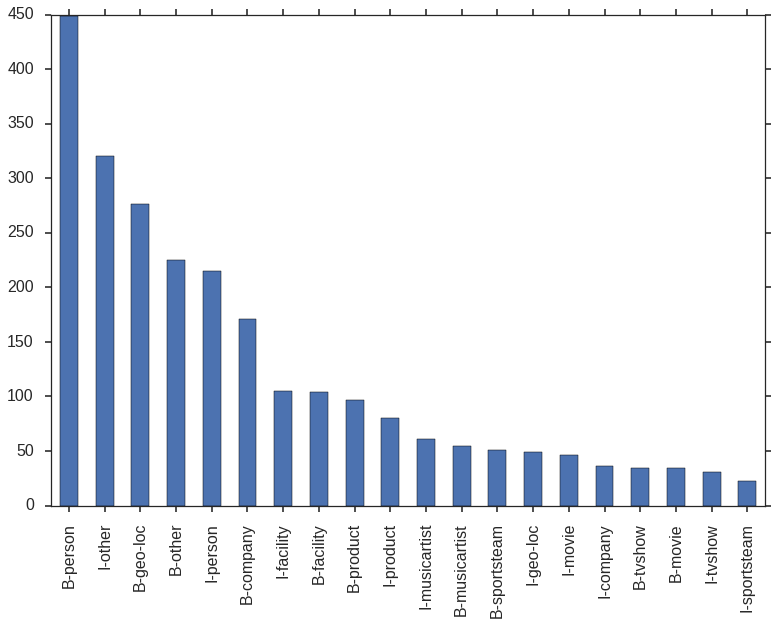

In [8]:
df[df.tag != "O"]["tag"].value_counts().plot(kind="bar")

In [9]:
lengths = count_phrases_lengths(sequences)

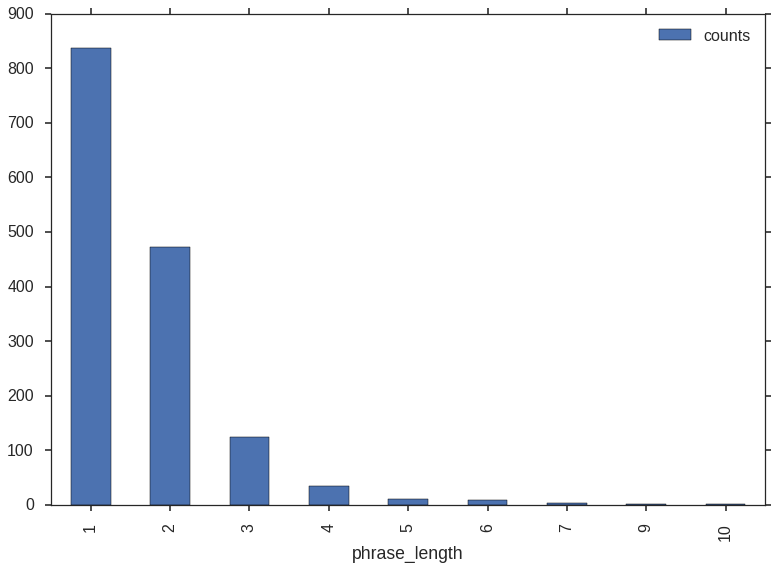

In [10]:
pd.DataFrame(Counter(lengths).items(), columns=["phrase_length", "counts"]).plot(x="phrase_length", y="counts", kind="bar")

## BIEOU

In [11]:
sequences, tag_count = load_sequences("data/cleaned/train.BIEOU.tsv", sep="\t")

In [12]:
df = pd.DataFrame(sum(sequences, []))
print df.shape
df.head()

(46469, 2)


,token,tag
0,@SammieLynnsMom,O
1,@tg10781,O
2,they,O
3,will,O
4,be,O


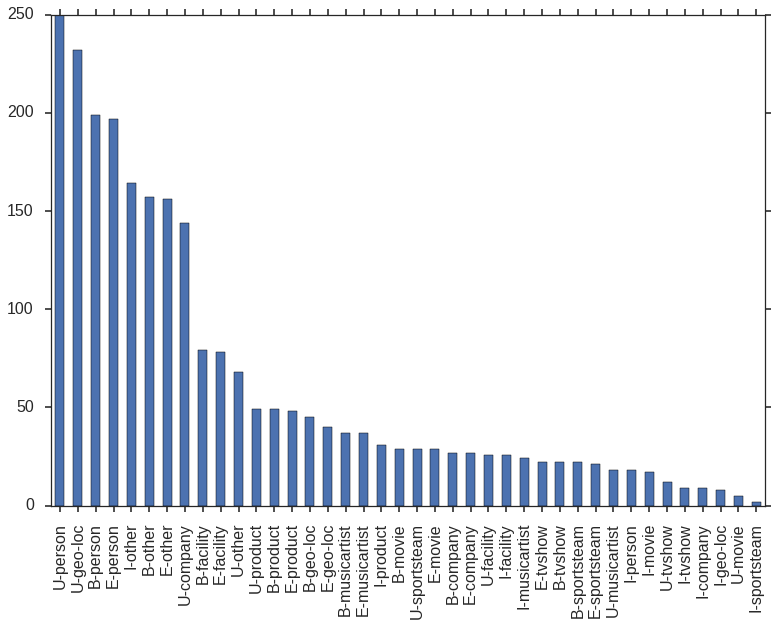

In [13]:
df[df.tag != "O"]["tag"].value_counts().plot(kind="bar")

In [14]:
df_t = df[df.tag != "O"]["tag"].value_counts().reset_index()
df_t[["Boundary", "Class"]] = df_t["index"].str.split("-", 1, expand=True)
df_t

,index,tag,Boundary,Class
0,U-person,250,U,person
1,U-geo-loc,232,U,geo-loc
2,B-person,199,B,person
3,E-person,197,E,person
4,I-other,164,I,other
5,B-other,157,B,other
6,E-other,156,E,other
7,U-company,144,U,company
8,B-facility,79,B,facility
9,E-facility,78,E,facility


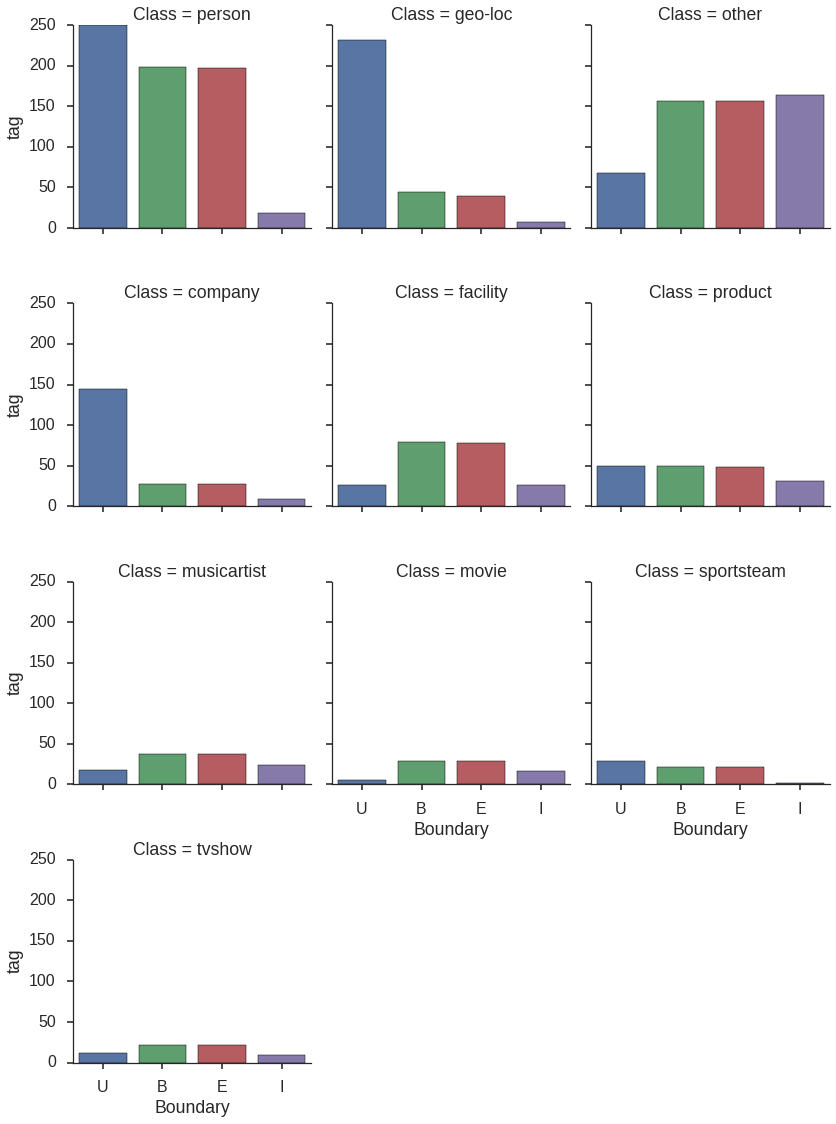

In [15]:
sns.factorplot(x="Boundary", y="tag", col="Class", data=df_t, col_wrap=3, kind="bar")

## Hashtags and Mentions

In [16]:
import regex as re

In [17]:
URL_REGEX = re.compile(r'^http[s]?://')
assert URL_REGEX.match("http://Google.com") is not None
assert URL_REGEX.match("https://Google.com") is not None
assert URL_REGEX.match("abchttps://Google.com") is None

In [18]:
REPEATED_CHAR_REGEX=re.compile(r'^[\.\,!\?"\':;_\-]{2,}$')
assert REPEATED_CHAR_REGEX.match("!") is None
assert REPEATED_CHAR_REGEX.match("!!") is not None
assert REPEATED_CHAR_REGEX.match("!?...!") is not None
assert REPEATED_CHAR_REGEX.match('".') is not None
assert REPEATED_CHAR_REGEX.match("aaaaa") is None
assert REPEATED_CHAR_REGEX.match('\".') is not None

In [19]:
WORD_REGEX=re.compile(r'^([A-Za-z]+[\'\-\.]?)+$')
assert WORD_REGEX.match("ABC") is not None
assert WORD_REGEX.match("ABC-D") is not None
assert WORD_REGEX.match("ABC'D") is not None
assert WORD_REGEX.match("ABC.DFC.") is not None
assert WORD_REGEX.match("9-1") is None
assert WORD_REGEX.match("A.B.C") is not None

In [20]:
PUNCT_REGEX=re.compile(ur'^\p{P}$')
assert PUNCT_REGEX.match(".") is not None
assert PUNCT_REGEX.match("?") is not None
assert PUNCT_REGEX.match("!") is not None
assert PUNCT_REGEX.match("aa") is None
assert PUNCT_REGEX.match("a.") is None

In [21]:
NUMBER_REGEX=re.compile(r'^(([0-9]*[.]?[0-9]+)|([0-9]+[,]?[0-9]+))$')
assert NUMBER_REGEX.match("123") is not None
assert NUMBER_REGEX.match("123,4") is not None
assert NUMBER_REGEX.match("12.5") is not None
assert NUMBER_REGEX.match(".5") is not None
assert NUMBER_REGEX.match("12-A") is None
assert NUMBER_REGEX.match(",55") is None
assert NUMBER_REGEX.match("5.5.55") is None

In [22]:
def get_token_type(t):
    if len(t.token) > 1 and t.token[0] in ['\'', '\"', '(', '-']:
        return get_token_type(Tag(t.token[1:], t.tag))
    if PUNCT_REGEX.match(t.token):
        return "Puctuation"
    if len(t.token) > 1 and t.token[0] == "@":
        return "Mention"
    if len(t.token) > 1 and t.token[0] == "#":
        return "Hashtag"
    if len(t.token) > 1 and t.token[0] == "$":
        return "Money"
    if URL_REGEX.match(t.token):
        return "URL"
    if NUMBER_REGEX.match(t.token):
        return "Number"
    if WORD_REGEX.match(t.token):
        return "Word"
    if t.token.isalnum():
        return "Alphanumeric"
    if REPEATED_CHAR_REGEX.match(t.token):
        return "Repeatedchar"
    return "Other"

In [23]:
pd.DataFrame(Counter(get_token_type(t) for seq in sequences for t in seq).most_common(), columns=["Type", "Counts"])

,Type,Counts
0,Word,36523
1,Puctuation,4848
2,Mention,1300
3,Other,1029
4,Repeatedchar,1010
5,Number,657
6,Hashtag,449
7,URL,448
8,Alphanumeric,185
9,Money,20


In [24]:
other_tokens = filter(lambda x: get_token_type(x) == "Money", (t for seq in sequences for t in seq))

In [25]:
token_counts = Counter(t.token for t in other_tokens).most_common()
for i, t in enumerate(token_counts):
    print "[%s] %s" % (i,t)

[0] ('$100', 2)
[1] ('$4T', 2)
[2] ('$6', 2)
[3] ('$4', 2)
[4] ('$5', 2)
[5] ('$1497-$3497', 1)
[6] ('$15', 1)
[7] ('$2/month', 1)
[8] ('$$', 1)
[9] ('$49', 1)
[10] ('$37K', 1)
[11] ('$150', 1)
[12] ('$320000', 1)
[13] ('$1000', 1)
[14] ('$1', 1)


## Build vocab

In [52]:
TYPE_MAPPINGS=OrderedDict({
    "Other": "OOV",
    "Hashtag": "#Hashtag",
    "Mention": "@Mention",
    "Puctuation": ".",
    "Number": "1111",
    "Money": "$100",
    "URL": "http://URL.com",
    "Repeatedchar": "..."
})

def get_vocab(sequences, prepend_extras=True):
    excluded_types=set(TYPE_MAPPINGS.keys())
    vocab = defaultdict(int)
    for seq in sequences:
        for t in seq:
            t_type = get_token_type(t)
            if t_type not in excluded_types:
                vocab[t.token] += 1
    id2word = ["OOV"]
    if prepend_extras:
        id2word = ["<MASK>", "<BOS>", "<EOS>"] + TYPE_MAPPINGS.values()
    id2word.extend([t[0] for t in sorted(vocab.iteritems(), key=lambda x: x[1], reverse=True)])
    print len(id2word)
    word2id = OrderedDict({k:i for i,k in enumerate(id2word)})
    return id2word, word2id, vocab
                
                
            

In [53]:
id2word, word2id, vocab = get_vocab(sequences)

8033


In [54]:
assert len(id2word) == len(word2id)

In [55]:
Counter(id2word).most_common(10)

[('Calaman', 1),
 ('four', 1),
 ('Does', 1),
 ('Olympics', 1),
 ('hanging', 1),
 ('Until', 1),
 ('LiLo', 1),
 ('LAST', 1),
 ('PAPALOTE', 1),
 ('otra', 1)]

In [56]:
with open("vocab.txt", "wb+") as fp:
    for t in id2word:
        print >> fp, t
print "Done"

id2word, word2id, vocab = get_vocab(sequences, prepend_extras=False)
with open("vocab.no_extras.txt", "wb+") as fp:
    for t in id2word:
        print >> fp, t
print "Done"

Done
8023
Done


## Phrase counts

In [31]:
def phrases_per_seq(sequences):
    count_phrases = []
    count_phrase_types = defaultdict(list)
    for seq in sequences:
        current_phrase_count = 0
        phrase_type_count = defaultdict(int)
        for t in seq:
            if t.tag[0] in ("U", "B"):
                current_phrase_count += 1
                phrase_type_count[t.tag[2:]] += 1
        count_phrases.append(current_phrase_count)
        for k,v in phrase_type_count.iteritems():
            count_phrase_types[k].append(v)
    return count_phrases, count_phrase_types
                

In [32]:
count_phrases, count_phrase_types = phrases_per_seq(sequences)

(array([ 1476.,   549.,   228.,    95.,    28.,    11.,     7.,     0.,
            0.]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 9 Patch objects>)

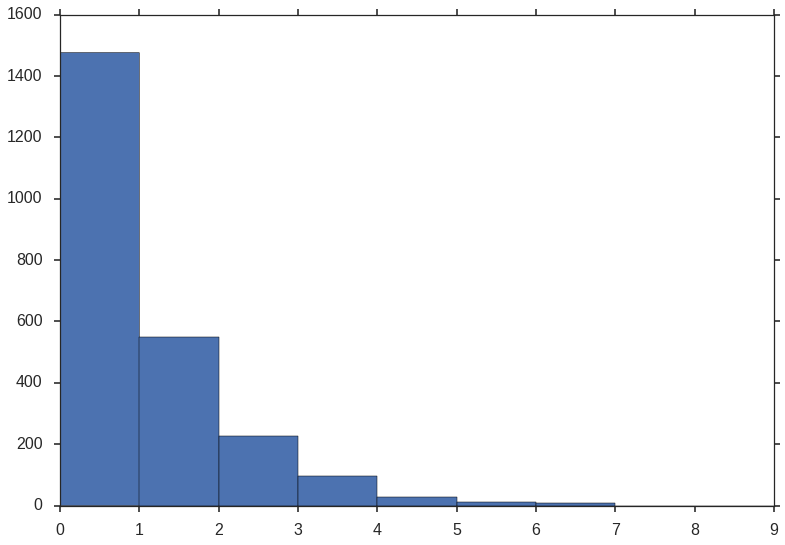

In [33]:
plt.hist(count_phrases, bins=range(10))

In [34]:
Counter(count_phrases)

Counter({0: 1476, 1: 549, 2: 228, 3: 95, 4: 28, 5: 11, 6: 7})

In [35]:
sum(Counter(count_phrases).values()) == len(sequences)

True

In [36]:
Counter(count_phrases)[0] * 100. / len(sequences)

61.65413533834587

In [37]:
count_phrases.index(6)

445

In [38]:
sequences[445]

[Tag(token='Yahoo', tag='U-company'),
 Tag(token=':', tag='O'),
 Tag(token='Jackie', tag='U-person'),
 Tag(token='joins', tag='O'),
 Tag(token='Twitter', tag='U-company'),
 Tag(token='50', tag='O'),
 Tag(token='years', tag='O'),
 Tag(token='after', tag='O'),
 Tag(token='JFK', tag='U-person'),
 Tag(token='campaign', tag='O'),
 Tag(token=':', tag='O'),
 Tag(token='Had', tag='O'),
 Tag(token='Twitter', tag='U-company'),
 Tag(token='been', tag='O'),
 Tag(token='an', tag='O'),
 Tag(token='option', tag='O'),
 Tag(token='in', tag='O'),
 Tag(token='1960', tag='O'),
 Tag(token=',', tag='O'),
 Tag(token='a', tag='O'),
 Tag(token='pregnant', tag='O'),
 Tag(token='Jacquelin', tag='U-person'),
 Tag(token='...', tag='O'),
 Tag(token='http://yhoo.it/9VAD4A', tag='O')]

In [39]:
for k, v in count_phrase_types.iteritems():
    print k, Counter(v)
    

product Counter({1: 56, 2: 11, 3: 4, 4: 2})
facility Counter({1: 84, 2: 9, 3: 1})
movie Counter({1: 20, 2: 2, 3: 2, 4: 1})
company Counter({1: 134, 2: 14, 3: 3})
sportsteam Counter({1: 33, 2: 9})
musicartist Counter({1: 35, 2: 4, 3: 4})
person Counter({1: 269, 2: 54, 3: 17, 4: 4, 5: 1})
other Counter({1: 166, 2: 23, 3: 3, 4: 1})
geo-loc Counter({1: 161, 2: 44, 3: 4, 4: 4})
tvshow Counter({1: 32, 2: 1})


## Context words

In [40]:
def phrases_context_words(sequences, lowercase=False):
    context_words = defaultdict(lambda : defaultdict(int))
    global_word_counts = defaultdict(int)
    for seq in sequences:
        phrase_types = set()
        outside_word_counts = defaultdict(int)
        for t in seq:
            token, tag = t
            if lowercase:
                token = token.lower()
            if tag[0] in ("U", "B"):
                phrase_types.add(tag[2:])
            elif t.tag[0] == "O":
                outside_word_counts[token] += 1
        for k,v in outside_word_counts.iteritems():
            global_word_counts[k] += 1
            for p in phrase_types:
                context_words[p][k] += v
    return context_words, global_word_counts         

In [41]:
context_words, global_word_counts = phrases_context_words(sequences, lowercase=True)

In [42]:
context_words.keys()

['product',
 'facility',
 'movie',
 'company',
 'sportsteam',
 'musicartist',
 'person',
 'other',
 'geo-loc',
 'tvshow']

In [43]:
def get_diff_type_occurence(w,context_words):
    n = 0
    for k, v in context_words.iteritems():
        if w in v:
            n += 1
    return n

In [44]:
TOPN=10
context_sums = {k: (sum(v.values())*1.) for k,v in context_words.iteritems()}
global_sum = len(context_words)*1.

for k,v in context_words.iteritems():
    print "Top %s tokens in category %s: " % (TOPN, k)
    print "\t", "\n\t".join("%s: %s" % t for t in sorted(v.iteritems(),
                                                   key=lambda x: ((x[1]/context_sums[k])
                                                                  *np.log10(global_sum/get_diff_type_occurence(x[0], context_words))),
                                                   reverse=True)[:10])

Top 10 tokens in category product: 
	refresh: 2
	mascara: 2
	tank: 2
	hand: 2
	record: 2
	monday: 3
	want: 5
	third: 2
	lo: 2
	mlia: 2
Top 10 tokens in category facility: 
	night: 10
	salsa: 2
	safety: 2
	self-defense: 2
	view: 2
	tamales: 2
	@paulwalk: 2
	soyrizo: 2
	saturday: 5
	where: 6
Top 10 tokens in category movie: 
	movie: 5
	5:00: 2
	8:45: 2
	@glasgowfilm: 2
	http://bit.ly/bhulum: 2
	7:00: 2
	applications: 2
	movies: 3
	really: 5
	:p: 2
Top 10 tokens in category company: 
	drama: 7
	@liltwist: 5
	edition: 7
	videos: 9
	meltdowns: 5
	epic: 6
	http://bit.ly/cuy0yt: 3
	cryin: 3
	usually: 4
	email: 4
Top 10 tokens in category sportsteam: 
	football: 7
	game: 13
	vs: 5
	scores: 3
	cheap: 2
	brooms: 2
	unseen: 2
	#ryerson: 2
	@robmoysey: 2
	@ruquidditch: 2
Top 10 tokens in category musicartist: 
	((: 2
	concerts: 2
	during/before: 2
	@jaredleto: 2
	rican: 2
	http://ht.ly/2g4ns: 2
	@planetill: 2
	stage: 2
	wants: 2
	costa: 2
Top 10 tokens in category person: 
	...": 14
	took: 17
	par

In [45]:
phrase_type_key="tvshow"
df_t = pd.DataFrame(context_words[phrase_type_key].items(), columns=["token", "count"])
df_t["normed_score"] = df_t.apply(lambda x: (x["count"] /context_sums[phrase_type_key]), axis=1)
df_t["normed_global_score"] = df_t.apply(lambda x: np.log10(global_sum/get_diff_type_occurence(x[0], context_words)), axis=1)
df_t["tf_idf"] = df_t["normed_score"]*df_t["normed_global_score"]
df_t.sort_values("tf_idf", ascending=False).head(10)

,token,count,normed_score,normed_global_score,tf_idf
217,loop,2,0.003503,1.00000,0.003503
277,@k8_walsh,2,0.003503,1.00000,0.003503
95,@fuseboxradio,2,0.003503,0.69897,0.002448
148,rican,2,0.003503,0.69897,0.002448
169,@planetill,2,0.003503,0.69897,0.002448
265,premiere,2,0.003503,0.69897,0.002448
100,stupid,2,0.003503,0.69897,0.002448
11,episodes,2,0.003503,0.69897,0.002448
152,http://ht.ly/2g4ns,2,0.003503,0.69897,0.002448
283,costa,2,0.003503,0.69897,0.002448


In [46]:
phrase_type_key="person"
df_t = pd.DataFrame(context_words[phrase_type_key].items(), columns=["token", "count"])
df_t["normed_score"] = df_t.apply(lambda x: (x["count"] /context_sums[phrase_type_key]), axis=1)
df_t["normed_global_score"] = df_t.apply(lambda x: np.log10(global_sum/get_diff_type_occurence(x[0], context_words)), axis=1)
df_t["tf_idf"] = df_t["normed_score"]*df_t["normed_global_score"]
df_t.sort_values("tf_idf", ascending=False).head(10)

,token,count,normed_score,normed_global_score,tf_idf
795,"...""",14,0.002070,0.698970,0.001447
206,took,17,0.002514,0.522879,0.001314
1225,part,14,0.002070,0.522879,0.001082
853,wake,7,0.001035,1.000000,0.001035
808,concert,10,0.001479,0.698970,0.001034
149,yoiu,6,0.000887,1.000000,0.000887
379,trampled,6,0.000887,1.000000,0.000887
170,got,24,0.003549,0.221849,0.000787
476,test,10,0.001479,0.522879,0.000773
1523,try,17,0.002514,0.301030,0.000757


In [47]:
phrase_type_key="geo-loc"
df_t = pd.DataFrame(context_words[phrase_type_key].items(), columns=["token", "count"])
df_t["normed_score"] = df_t.apply(lambda x: (x["count"] /context_sums[phrase_type_key]), axis=1)
df_t["normed_global_score"] = df_t.apply(lambda x: np.log10(global_sum/get_diff_type_occurence(x[0], context_words)), axis=1)
df_t["tf_idf"] = df_t["normed_score"]*df_t["normed_global_score"]
df_t.sort_values("tf_idf", ascending=False).head(10)

,token,count,normed_score,normed_global_score,tf_idf
956,party,10,0.002571,0.397940,0.001023
420,follow,6,0.001542,0.522879,0.000806
1199,forward,3,0.000771,1.000000,0.000771
245,f,3,0.000771,1.000000,0.000771
135,3d,3,0.000771,1.000000,0.000771
573,sony/bud,3,0.000771,1.000000,0.000771
859,light,3,0.000771,1.000000,0.000771
517,http://bit.ly/cds8pd,3,0.000771,1.000000,0.000771
830,etc,4,0.001028,0.698970,0.000719
263,beautiful,4,0.001028,0.698970,0.000719
